In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [2]:
df_rootDataset = pd.read_csv("./data/rootDataset.csv")

In [3]:
for col in df_rootDataset.columns:
    print(col)

icustay_id
urineoutput
age
pulmonary
vent
heartrate_min
heartrate_max
heartrate_mean
sysbp_min
sysbp_max
sysbp_mean
diasbp_min
diasbp_max
diasbp_mean
meanbp_min
meanbp_max
meanbp_mean
resprate_min
resprate_max
resprate_mean
tempc_min
tempc_max
tempc_mean
spo2_min
spo2_max
spo2_mean
glucose_mean
mingcs
gcsmotor
gcsverbal
gcseyes
endotrachflag
aniongap_min
aniongap_max
albumin_min
albumin_max
bands_min
bands_max
bicarbonate_min
bicarbonate_max
bilirubin_min
bilirubin_max
creatinine_min
creatinine_max
chloride_min
chloride_max
glucose_min
glucose_max
hematocrit_min
hematocrit_max
hemoglobin_min
hemoglobin_max
lactate_min
lactate_max
platelet_min
platelet_max
potassium_min
potassium_max
ptt_min
ptt_max
inr_min
inr_max
pt_min
pt_max
sodium_min
sodium_max
bun_min
bun_max
wbc_min
wbc_max
specimen
specimen_pred
specimen_prob
so2
spo2
po2
pco2
fio2_chartevents
fio2
aado2
aado2_calc
pao2fio2
ph
baseexcess
bicarbonate
totalco2
hematocrit
hemoglobin
carboxyhemoglobin
methemoglobin
chloride
calcium

In [4]:
medical_score_features = [['GCS','Heart rate',' mean blood pressure','temperature','respiration rate','ventilation/cpap','chronic dialysis','urine output','Pao2','A-aDO2','hematocrit','WBC','creatinine','blood urea nitrogen','sodium','albumin','bilirubin','glucose','pH','pCO2'],            ['GCS','Heart rate','systolic blood pressure','ventilation/cpap','urine output','blood urea nitrogen','WBC','bilirubin','creatinine','prothrombin time (PT)','platelets','PaO2/FiO2 ratio',],                                                                  
                          ['GCS','Heart rate','systolic blood pressure','ventilation/cpap','WBC',' bilirubin','creatinine','platelets','PaO2/FiO2 ratio'],                                                                                                                                
                          ['Heart rate','GCS','MAP','temperature','respiration rate','Ventilation status','urine output','Elective surgery','Pre-ICU in-hospital length of stay','Age'],                                                                                                  
                          ['GCS','respiration rate','systolic blood pressure'],                                                                                                                                                                                                           
                          ['Age','GCS','Heart rate','systolic blood pressure','temperature','respiration rate','ventilation/cpap','urine output','blood urea nitrogen','hematocrit','WBC','glucose','potassium','sodium','HCO3'],                                                         
                          ['Age','GCS','Heart rate','systolic blood pressure','temperature','ventilation/cpap','urine output','PaO2/FiO2 ratio','blood urea nitrogen','WBC','potassium','sodium','HCO3'],                                                                                
                          ['Body temperature','Heart rate','respiration rate','PaCO2','White blood cell count'],                                                                                                                                                                           
                          ['GCS','MAP','FiO2','Ventilation status','Creatinine','Bilirubin','PaO2','Platelets','Dobutamine','Epinephrine','Norepinephrine','urine output']]

In [5]:
result = TransactionEncoder().fit(medical_score_features).transform(medical_score_features)
features = []
for valArr, nameArr in zip(result, medical_score_features):
    for val, name in zip(valArr, nameArr):
        if(val and name not in features):
            features.append(name)

In [6]:
df_fpm = pd.DataFrame([df_rootDataset["heartrate_mean"], df_rootDataset["meanbp_mean"], df_rootDataset["wbc_min"], df_rootDataset["wbc_max"], df_rootDataset["pco2"], df_rootDataset["pao2fio2"], df_rootDataset["mingcs"], df_rootDataset["temperature"], df_rootDataset["los"], df_rootDataset["sysbp_mean"], df_rootDataset["glucose_mean"], df_rootDataset["sodium_min"], df_rootDataset["sodium_max"], df_rootDataset["creatinine_min"], df_rootDataset["creatinine_max"], df_rootDataset["platelet_min"], df_rootDataset["platelet_max"], df_rootDataset["urineoutput"], df_rootDataset["icu_level"]]).transpose()
for col in df_fpm:
    print(col)

heartrate_mean
meanbp_mean
wbc_min
wbc_max
pco2
pao2fio2
mingcs
temperature
los
sysbp_mean
glucose_mean
sodium_min
sodium_max
creatinine_min
creatinine_max
platelet_min
platelet_max
urineoutput
icu_level


In [7]:
df_fpm.describe().T

,count,mean,std,min,25%,50%,75%,max
heartrate_mean,164174.0,89.079434,16.693729,34.090909,78.607143,86.750000,97.150000,195.565217
meanbp_mean,160780.0,76.823518,9.658530,17.428571,70.500000,75.391304,81.615385,136.217680
wbc_min,162595.0,10.849886,7.129492,0.100000,7.100000,10.000000,13.300000,442.700000
wbc_max,162595.0,15.451717,10.084107,0.100000,10.500000,14.000000,18.500000,600.200000
pco2,164180.0,41.964716,11.244013,7.000000,36.000000,40.000000,46.000000,243.000000
pao2fio2,85658.0,266.684299,129.532481,13.000000,173.333333,250.000000,344.999995,2433.333333
mingcs,160503.0,13.565890,3.191264,3.000000,14.000000,15.000000,15.000000,15.000000
temperature,27505.0,37.027853,1.196427,10.000000,36.400000,37.100000,37.700000,42.100000
los,164184.0,6.660082,11.219754,0.038200,1.752800,3.114700,6.827200,173.072500
sysbp_mean,160553.0,115.328429,14.471562,29.166667,105.633333,112.872340,122.640000,197.200000


In [8]:
for colType, colName in zip(df_fpm.dtypes, df_fpm.columns):
    print(colName, colType) 

heartrate_mean float64
meanbp_mean float64
wbc_min float64
wbc_max float64
pco2 float64
pao2fio2 float64
mingcs float64
temperature float64
los float64
sysbp_mean float64
glucose_mean float64
sodium_min float64
sodium_max float64
creatinine_min float64
creatinine_max float64
platelet_min float64
platelet_max float64
urineoutput float64
icu_level float64


In [9]:
# for colName in df_fpm.columns:
#     print("-------- Hist / Rug plot for {}".format(colName))
#     sns.histplot(x=df_fpm[colName], data=df_fpm, kde=True, bins=70)
#     plt.show()

<AxesSubplot:>

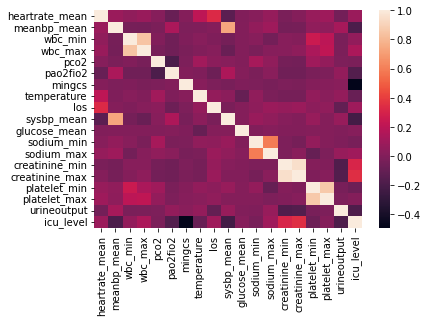

In [10]:
corr = df_fpm.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [11]:
target = df_fpm.pop("icu_level")
X_train, X_test, y_train, y_test = train_test_split(df_fpm, target, test_size=0.33, random_state=42)

In [12]:
target.size

164184

In [13]:
df_fpm.shape

(164184, 18)

In [14]:
train = xgb.DMatrix(X_train,label=y_train)
test  = xgb.DMatrix(X_test,label=y_test)

In [15]:
epochs = 10
param = {
    'eta':0.9,
    'objective': 'multi:softmax',
    'num_class': 4
}

In [16]:
model = xgb.train(param, train, epochs)

In [17]:
pred = model.predict(test)
acc = accuracy_score(y_test,pred)

In [18]:
print("Model Accuracy :",acc)
print(y_train.value_counts())

Model Accuracy : 0.8856794817371403
1.0    77094
2.0    23163
3.0     9746
Name: icu_level, dtype: int64


In [19]:
cm = confusion_matrix(y_test, pred)

In [20]:
y_test.shape

(54181,)

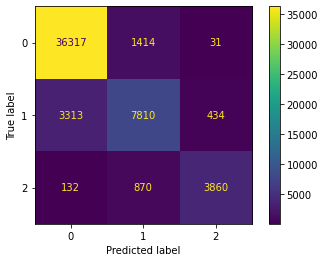

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [22]:
c_train = xgb.DMatrix(df_fpm,label=target)

In [23]:
res = xgb.cv(param, c_train, num_boost_round=epochs, nfold=5,
             metrics={'merror'}, seed=0,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False),
                        xgb.callback.EarlyStopping(3)])
print(res)                        

[0]	train-merror:0.17257	test-merror:0.17615
[1]	train-merror:0.15801	test-merror:0.16201
[2]	train-merror:0.14694	test-merror:0.15180
[3]	train-merror:0.13789	test-merror:0.14484
[4]	train-merror:0.12986	test-merror:0.13807
[5]	train-merror:0.12337	test-merror:0.13180
[6]	train-merror:0.11860	test-merror:0.12771
[7]	train-merror:0.11288	test-merror:0.12277
[8]	train-merror:0.10820	test-merror:0.11914
[9]	train-merror:0.10396	test-merror:0.11511
   train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0           0.172569          0.001429          0.176150         0.001255
1           0.158010          0.001064          0.162013         0.001328
2           0.146943          0.001222          0.151799         0.001741
3           0.137893          0.000786          0.144837         0.001162
4           0.129863          0.000843          0.138071         0.002523
5           0.123369          0.001815          0.131797         0.002037
6           0.118603          0.

In [24]:
xgb_class = XGBClassifier(param, num_boost_round=epochs, nfold=5,
             metrics={'merror'}, seed=0)
xgb_class                    

d:\dev\github\MICUP-V2.0\.venv\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, metrics={'merror'}, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, nfold=5, num_boost_round=10, num_parallel_tree=None,
              objective={'eta': 0.9, 'num_class': 4,
                         'objective': 'multi:softmax'}, ...)

In [25]:
le = LabelEncoder()
target = le.fit_transform(target)
target

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_fpm, target, test_size=0.33, random_state=42)

In [27]:
xgb_class.fit(X_train, y_train)

[18:44:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metrics", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, metrics={'merror'},
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, nfold=5, num_boost_round=10,
              num_parallel_tree=1, objective='multi:softprob', ...)

In [28]:
y_predicted = xgb_class.predict(X_test)

In [29]:
acc = accuracy_score(y_test,y_predicted)
print("Model Accuracy :",acc)

Model Accuracy : 0.93667521824994


In [30]:
cm = confusion_matrix(y_test, y_predicted)

In [31]:
y_test.shape

(54181,)

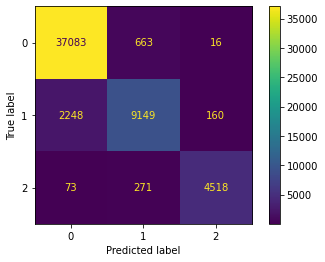

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [33]:
df_fpm.columns

Index(['heartrate_mean', 'meanbp_mean', 'wbc_min', 'wbc_max', 'pco2',
       'pao2fio2', 'mingcs', 'temperature', 'los', 'sysbp_mean',
       'glucose_mean', 'sodium_min', 'sodium_max', 'creatinine_min',
       'creatinine_max', 'platelet_min', 'platelet_max', 'urineoutput'],
      dtype='object')